In [1]:
import numpy as np
import torch.optim as opt
from torch import nn
import torch
from torch.distributions import Normal, Uniform
import random
from math import log
import matplotlib.pyplot as plt
import torch.nn.functional as F
import plotly.graph_objects as go

import pickle

In [57]:
with open('hw2_q2.pkl', 'rb') as file:
    data = pickle.load(file)
data['train'][:, :, :, [0, 1, 2]] = data['train'][:, :, :, [2, 1, 0]]
data['test'][:, :, :, [0, 1, 2]] = data['test'][:, :, :, [2, 1, 0]]

In [55]:
data['train'].shape

(20000, 32, 32, 3)

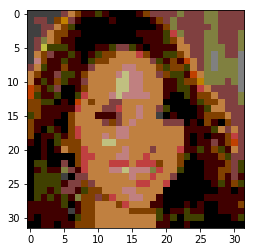

In [54]:
plt.imshow((data['train'] * 64)[100])

In [59]:
train = data['train'].transpose(0, 3, 1, 2)
test = data['test'].transpose(0, 3, 1, 2)

In [60]:
class LossAggregator:
    def __init__(self):
        self.loss = 0

class RealNVPLayer(nn.Module):
    def __init__(self, h, w, inv, s, t, losser):
        super(RealNVPLayer, self).__init__()
        ranged = np.arange(h * w).reshape(h, w)
        self.mask = torch.from_numpy(((ranged + ranged // w + inv) % 2).reshape(h * w))
        self.s = s
        self.t = t
        self.losser = losser
        
    def forward(self, x):
        self.losser.loss = (1 - self.mask) * self.s(self.mask * x) + self.losser.loss
        return x * self.mask + (1 - self.mask) * (x * self.s(self.mask * x).exp() + self.t(self.mask * x))

In [61]:
class GlowLayer(nn.Module):
    def __init__(self, size, losser):
        super(GlowLayer, self).__init__()
        self.size = size
        self.losser = losser
        self.w = nn.Parameter(torch.ones(size))
        self.b = nn.Parameter(torch.zeros(size))

    def forward(self, x):
        x = self.w * x + self.b
        log_det = torch.log(self.w.abs() + 1e-9)
        self.losser.loss += log_det
        return x

class RealNVP(nn.Module):
    def __init__(self, h, w, num_of_layers, s_gen, t_gen):
        super(RealNVP, self).__init__()
        self.h = h
        self.w = w
        layers = []
        self.losser = LossAggregator()
        for i in range(num_of_layers):
            layers.append(RealNVPLayer(h, w, i%2, s_gen(h, w), t_gen(h, w), self.losser))
            layers.append(GlowLayer(h * w, self.losser))    
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
        
    def forward(self, batch):
        batch = torch.tensor(batch, requires_grad=False).view(-1, self.h * self.w).float()
        self.losser.loss = 0
        result = self.net(batch)
        return result, torch.sum((self.losser.loss + torch.log(result * (1 - result) + 1e-9)).view(-1, 2), dim=1)